# Solving second order ODE

In this notebook we will solve a second order ode. We will assume the following trial solution:
<p style="text-align: center;">$y_t(x) = \frac{B}{b - a}(x - a) + \frac{A}{b - a}(b - x) + (b-x)(x-a)N(x, P)$</p>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import ScalarFormatter

COMP = "Output comparison"
LOSS = "Cost curve"

## Define a class for solving the ode

All equations are present in the paper

In [2]:
# python class for solving ode, all equations presented will be linked to equations presented on paper

COMP = "Output comparison"
LOSS = "Cost curve"

class SecondODE():
    import numpy as np
    import matplotlib.pyplot as plt
    

    # passed functions must accept numpy arrays as inputs
    def __init__(self, w, b, v, func, func_der, a, A, c, C):
        
        # first set of weights
        self.w = self.np.reshape(self.np.array(w), (-1, 1)) 
        # biases
        self.b = self.np.reshape(self.np.array(b), (-1, 1)) 
        # second set of weights
        self.v = self.np.reshape(self.np.array(v), (-1, 1))
        
        # function from cost function f(x, y, dy)
        self.func = func
        
        # derivative of function from cost function df(x, y)/dy
        self.func_der = func_der 
        
        # values for boundry definition
        self.a = a
        self.A = A
        self.c = c
        self.C = C
        
    
    
    
    #### calculations ####
    """calc the output of certain array of inputs of nn of certain order --> equation 3 + equation 9"""
    def compute(self, inp, order):
        hid_layer = self.np.add(self.np.dot(inp, self.np.transpose(self.w)), self.np.transpose(self.b))
        act_func = self.sigmoid(hid_layer, order)
        return self.np.dot(act_func, (self.v * self.w**order))
    

    """calc the cost of a certain set of points --> equation 4"""
    def cost(self, inp):
        y = self.get_y_trial(inp, 0)
        dy = self.get_y_trial(inp, 1)
        ddy = self.get_y_trial(inp, 2)
        
        return self.np.mean((ddy - self.func(inp, y, dy))**2)
    
    
    def get_y_trial_zero(self, inp):
        Al = self.A/(self.c - self.a)
        Cl = self.C/(self.c - self.a)
        
        return Al*(self.c - inp) + Cl*(inp - self.a) + (self.c - inp)*(inp - self.a)*self.compute(inp, 0)
    
    def get_y_trial_first(self, inp):
        Al = self.A/(self.c - self.a)
        Cl = self.C/(self.c - self.a)
        eq_1 = (-2*inp + (self.c+self.a))*self.compute(inp, 0)
        eq_2 = (-(inp**2) +(self.c+self.a)*inp - self.c*self.a)*self.compute(inp, 1)
        
        return -Al + Cl + eq_1 + eq_2
    
    def get_y_trial_second(self, inp):
        eq_1 = (-(inp**2) +(self.c+self.a)*inp - self.c*self.a)*self.compute(inp, 2)
        
        return -2*self.compute(inp, 0) + 2*(-2*inp + (self.c+self.a))*self.compute(inp, 1) + eq_1
    
    def get_y_trial(self, inp, order):
        if order == 0:
            return self.get_y_trial_zero(inp)
        elif order == 1:
            return self.get_y_trial_first(inp)
        elif order == 2:
            return self.get_y_trial_second(inp)
    
    
    
    
    #### optimization ####
    """update nn weights using sigmoid --> equation 5"""
    def update_weights(self, inp, l_rate):
      
        sp_cost = self.simple_cost(inp)
        
        new_b = self.np.zeros(self.b.shape)
        new_v = self.np.zeros(self.v.shape)
        new_w = self.np.zeros(self.w.shape)

        #update weight
        for i in range(len(self.w)): # number of neurons in hidden layer
            
            # update bias ## --> equation 8
            new_b[i] = self.b[i] - l_rate*(2*np.mean(sp_cost * self.cost_derive_b(inp, self.w[i], self.b[i], self.v[i])))
            
            # update v ## --> equation 8
            new_v[i] = self.v[i] - l_rate*(2*np.mean(sp_cost * self.cost_derive_v(inp, self.w[i], self.b[i])))
            
            # update w ## --> equation 8
            new_w[i] = self.w[i] - l_rate*(2*np.mean(sp_cost * self.cost_derive_w(inp, self.w[i], self.b[i], self.v[i])))

        self.b = new_b
        self.v = new_v
        self.w = new_w

    """simple cost is a constant value used in cost function and derivative"""
    def simple_cost(self, inp):
        y = self.get_y_trial(inp, 0)
        dy = self.get_y_trial(inp, 1)
        ddy = self.get_y_trial(inp, 2)
        
        return ddy - self.func(inp, y, dy)

    
    ## beta ##
    """derivative of N in respect to beta --> equation 11"""
    def derive_b(self, inp, w, b, v, order):
        return v * w**order * self.sigmoid(w*inp+b, order+1)
    
    # derivative of cost derived from trial solution: use to reduce line size 
    def cost_derive_b(self, inp, w, b, v):
        eq_1 = -2*self.derive_b(inp,w,b,v,0) + 2*(-2*inp + (b+a))*self.derive_b(inp,w,b,v, 1)
        
        return eq_1 + (-(inp**2) + (b+a)*inp + b*a)*self.derive_b(inp,w,b,v,2)
    
    ## v ##
    """derivative of N in respect to v --> equation 12"""
    def derive_v(self, x, w, b, order):
        return w**order * self.sigmoid(x*w+b, order)
    
    # derivative of cost derived from trial solution: use to reduce line size 
    def cost_derive_v(self, inp, w, b):
        eq_1 = -2*self.derive_v(inp,w,b,0) + 2*(-2*inp + (b+a))*self.derive_v(inp,w,b, 1)
        
        return eq_1 + (-(inp**2) + (b+a)*inp + b*a)*self.derive_v(inp,w,b,2)
    
    
    ## w ##
    """derivative of N in respect to w --> equation 10"""
    def derive_w(self, x, w, b, v, order):
        z=w*x+b
        if order == 0:
            return v*x*self.sigmoid(w*x+b, order)
        else:
            return v*(order*(w**(order-1))*self.sigmoid(z, order) + x*(w**order)*self.sigmoid(z, order+1))
    
    # derivative of cost derived from trial solution: use to reduce line size 
    def cost_derive_w(self, inp, w, b, v):
        eq_1 = -2*self.derive_w(inp,w,b,v,0) + 2*(-2*inp + (b+a))*self.derive_w(inp,w,b,v, 1)
        
        return eq_1 + (-(inp**2) + (b+a)*inp + b*a)*self.derive_w(inp,w,b,v,2)
    



    ### desired output ###
    """get trial solution value --> equation 6"""
    def get_real_values(self, inp):
        base = self.b - self.a
        return self.A/base * (self.b - inp) + self.B/base * (x - self.a) + (self.b - x)*(x - self.a)*self.compute(x, 0)
    


    ##### sigmoid and derivatives #####
    def sig(self, x): 
        return 1/(1 + self.np.exp(-x))

    def sig_first(self, x): # first derivative of sigmoid
        return self.sig(x)*(1 - self.sig(x))

    def sig_second(self, x): # second derivative of sigmoid
        return self.sig(x)*(1 - self.sig(x))*(1 - 2*self.sig(x))
    
    def sig_third(self, x): # second derivative of sigmoid
        return self.sig_second(x)*(1 -2*self.sig(x)) + -2*self.sig_first(x)*self.sig_first(x)

    def sigmoid(self, x, order):
        if order == 0:
            return self.sig(x)
        elif order == 1:
            return self.sig_first(x)
        elif order == 2:
            return self.sig_second(x)        
        elif order == 3:
            return self.sig_third(x)  
        

## Problem 4

$$
  \frac{d^2y}{dx^2} = \cos(x),\quad y(0) = 1,\quad y\left(\frac{\pi}{2}\right)=2,
$$

We will solve for $x \in \left [0,\frac{\pi}{2}  \right ] $.

11.596575213264646
0.0005538359813257694


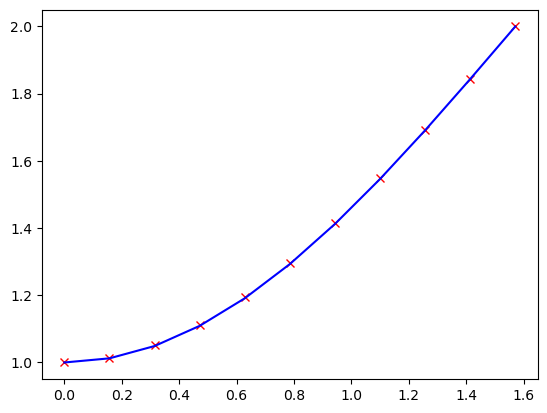

In [3]:
weights = [0.2, 0.3, 0.3,      0.4, 0.5, 0.5,      0.6, 0.7, 0.8]

def f(x, y, dy):
    return np.cos(x)

def f_der(x, y, dy):
    return 0

def real_sol(x):
    return -np.cos(x) + 2

A = 1
C = 2
a = 0
c = np.pi/2

k_points = 11 - 1
global_inp = np.arange(a, c+(c-a)/k_points, (c-a)/k_points)
global_inp = np.reshape(global_inp, (-1, 1))

odesolver = SecondODE([0.2, 0.3, 0.3], [0.4, 0.5, 0.5], [0.6, 0.7, 0.8], f, f_der, a, A, c, C)

print(odesolver.cost(global_inp))
for i in range(70000):
    odesolver.update_weights(global_inp, 0.01)

print(odesolver.cost(global_inp))

plt.plot(global_inp, odesolver.get_y_trial(global_inp, 0), 'rx', global_inp, real_sol(global_inp), 'b-')

Text(0, 0.5, 'Cost')

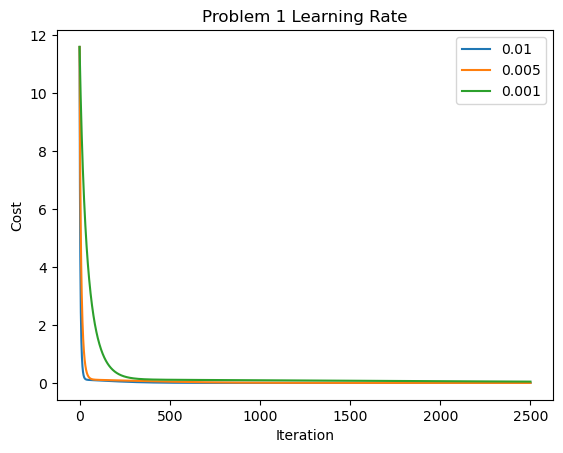

In [4]:
# for testing different learning rates
ode_solver_lr_1 = []
ode_solver_lr_1.append(SecondODE([0.2, 0.3, 0.3], [0.4, 0.5, 0.5], [0.6, 0.7, 0.8], f, f_der, a, A, c, C))
ode_solver_lr_1.append(SecondODE([0.2, 0.3, 0.3], [0.4, 0.5, 0.5], [0.6, 0.7, 0.8], f, f_der, a, A, c, C))
ode_solver_lr_1.append(SecondODE([0.2, 0.3, 0.3], [0.4, 0.5, 0.5], [0.6, 0.7, 0.8], f, f_der, a, A, c, C))
cost_1 = [] 



# start cost (make sure is the same)
for i in range(3):
    cost_1.append([ode_solver_lr_1[i].cost(global_inp)])

# training nn
lr_1 = [0.01, 0.005, 0.001]
for n in range(2500):
    for i in range(3):
        ode_solver_lr_1[i].update_weights(global_inp, lr_1[i])
        cost_1[i].append(ode_solver_lr_1[i].cost(global_inp))
        
for i in range(3):
    plt.plot(cost_1[i])
plt.legend(lr_1)
plt.title("Problem 1 Learning Rate")
plt.xlabel("Iteration")
plt.ylabel("Cost")

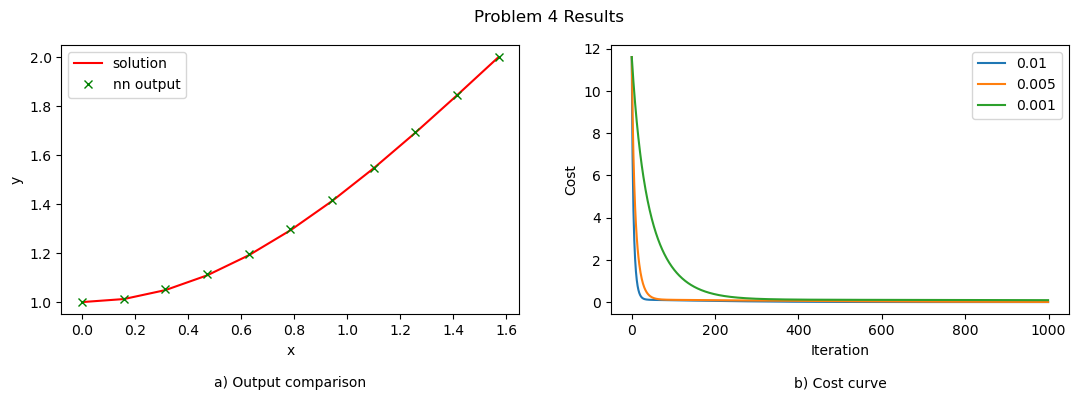

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3.5))


ax1.plot(global_inp, real_sol(global_inp), 'r-', global_inp, odesolver.get_y_trial(global_inp, 0), 'gx')
ax1.legend(["solution", "nn output"])
ax1.set_xlabel("x\n\na) " + COMP)
ax1.set_ylabel("y")



for i in range(3):
    plt.plot(cost_1[i][:1000])
ax2.legend(lr_1)
ax2.set_xlabel("Iteration\n\nb) "+ LOSS)
ax2.set_ylabel("Cost")

fig.suptitle('Problem 4 Results')

resolution_value = 1200
fig.savefig("prob4.pdf", format="pdf", dpi=resolution_value, bbox_inches = 'tight')

## Problem 5

$$
  \frac{d^2y}{dx^2} = -(y+2y^3), ~~y(-10) = 0, y(10)=0
$$

We will solve for x in [-10, 10].

740042.9532555325
740042.9532555325


/var/folders/ly/wmvsl7n93sjgzpnsd4vld8cc0000gn/T/ipykernel_34131/3320511832.py:169: RuntimeWarning: overflow encountered in exp
  return 1/(1 + self.np.exp(-x))


401778.14285714284
401778.14285714284
401778.14285714284
401778.14285714284
401778.14285714284


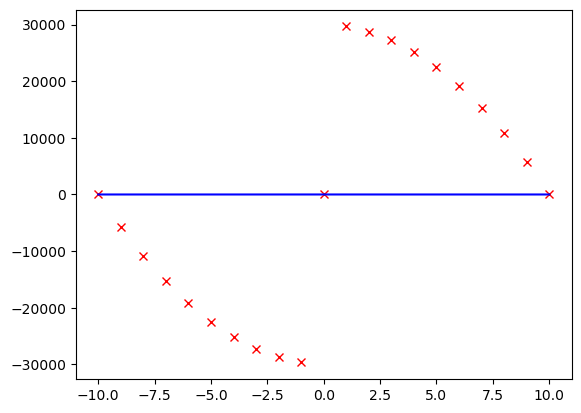

In [6]:
def f(x, y, dy):
    return x-2*(x**3)

def f_der(x, y, dy):
    return 0

def real_sol(x):
    return 2/(np.exp(x) + np.exp(-x))

A = 0
C = 0
a = -10
c = 10

k_points = 20
global_inp = np.arange(a, c+(c-a)/k_points, (c-a)/k_points)
global_inp = np.reshape(global_inp, (-1, 1))


odesolver = SecondODE([0.2, 0.3, 0.3], [0.4, 0.5, 0.5], [0.6, 0.7, 0.8], f, f_der, a, A, c, C)

print(odesolver.cost(global_inp))
for i in range(500000):
    if i % 100000 == 0:
        print(odesolver.cost(global_inp))
        
    odesolver.update_weights(global_inp, 0.01)

print(odesolver.cost(global_inp))

plt.plot(global_inp, odesolver.get_y_trial(global_inp, 0), 'rx', global_inp, real_sol(global_inp), 'b-')